In [2]:
import torch
import torch.nn as nn
import tiktoken
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
import re

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, _ = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

In [4]:
class GPTBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ln1 = nn.LayerNorm(cfg["emb_dim"])
        self.attn = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]  # Match your original config

        )
        self.ln2 = nn.LayerNorm(cfg["emb_dim"])
        self.ffn = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            nn.Dropout(cfg["drop_rate"])
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))  # Residual connection
        x = x + self.ffn(self.ln2(x))   # Residual connection
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])
        self.blocks = nn.Sequential(*[GPTBlock(cfg) for _ in range(cfg["n_layers"])])
        self.ln_f = nn.LayerNorm(cfg["emb_dim"])
        self.head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

        # Weight tying and initialization
        self.head.weight = self.tok_emb.weight
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()

        # Token and position embeddings
        tok_emb = self.tok_emb(idx)
        pos = torch.arange(0, t, dtype=torch.long, device=device)
        pos_emb = self.pos_emb(pos)

        x = self.drop(tok_emb + pos_emb)
        x = self.blocks(x)
        x = self.ln_f(x)
        return self.head(x)

In [5]:
# --------------------- CONFIG ---------------------
GPT_CONFIG = {
    "vocab_size": 50257,
    "context_length": 128,
    "emb_dim": 256,  # Changed for smaller GPT
    "n_heads": 4,     # Reduced heads
    "n_layers": 4,    # Fewer layers for faster training
    "drop_rate": 0.1, # Lower dropout
    "qkv_bias": True
}

TRAIN_CONFIG = {
    "batch_size": 32,  # Increased for stability (adjust for GPU memory)
    "learning_rate": 6e-4,  # Increased LR for smaller models
    "weight_decay": 0.98,    # Reduced weight decay
    "num_epochs": 50,       # More epochs for better learning
    "eval_freq": 100,
    "eval_iter": 20,
    "generation_temp": 0.8,
    "top_k": 40,
    "top_p": 0.9,  # Slightly more exploration
    "gradient_clip": 1.0,
    "warmup_steps": 1000,
    "checkpoint_path": "best_model.pth"
}

In [6]:
# ------------------ TEXT CLEANING ------------------
def clean_text(text):
    """Clean while preserving narrative structure"""
    # 1. Standardize quotes and special chars (keep apostrophes)
    text = (text.replace('“', '"').replace('”', '"')
                .replace('’', "'").replace('—', ' -- '))

    # 2. Clean chapter headings (format consistently)
    text = re.sub(r'CHAPTER\s+([IVXLCDM]+)\s*\n([A-Z\s]+)\n',
                 r'CHAPTER \1\n\2\n\n', text, flags=re.IGNORECASE)

    # 3. Normalize whitespace (preserve paragraph breaks)
    text = re.sub(r'(\n)\s+', r'\1', text)  # Remove leading space after newline
    text = re.sub(r'[ \t]+', ' ', text)     # Collapse multiple spaces/tabs

    # 4. Fix line breaks in dialogue/mid-paragraph
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)  # Replace single newlines with space
    text = re.sub(r'\n{3,}', '\n\n', text)        # Limit consecutive newlines

    return text.strip()


def prepare_text(raw_text):
    """Main text preparation pipeline"""
    text = clean_text(raw_text)

    # Optional: Remove very short sentences (adjust min_len as needed)
    if False:  # Set to True if needed
        text = remove_short_sentences(text, min_len=20)

    return text

In [7]:
# ------------------ DATASET CLASS ------------------
class HarryPotterDataset(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        token_ids = tokenizer.encode_ordinary(text)
        if len(token_ids) < max_length:
            raise ValueError(f"Too few tokens ({len(token_ids)}). Need at least {max_length}.")
        self.input_ids, self.target_ids = [], []
        for i in range(0, len(token_ids) - max_length, stride):
            chunk = token_ids[i:i+max_length+1]
            self.input_ids.append(torch.tensor(chunk[:-1]))
            self.target_ids.append(torch.tensor(chunk[1:]))

    def __len__(self): return len(self.input_ids)
    def __getitem__(self, idx): return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(text, tokenizer, batch_size, max_length, stride, shuffle=True):
    dataset = HarryPotterDataset(text, tokenizer, max_length, stride)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

In [8]:
# ----------------- GENERATION FUNC -----------------
def generate_text(model, tokenizer, device, start_context, max_length=100, temperature=0.8, top_k=40, top_p=0.9):
    model.eval()
    encoded = torch.tensor(tokenizer.encode(start_context), dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        for _ in range(max_length):
            input_ids = encoded[:, -GPT_CONFIG["context_length"]:]
            logits = model(input_ids)[:, -1, :] / temperature

            if top_k:
                top_k_val, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < top_k_val[:, [-1]]] = -float('Inf')

            if top_p:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                probs = torch.softmax(sorted_logits, dim=-1)
                cum_probs = torch.cumsum(probs, dim=-1)
                remove = cum_probs > top_p
                remove[..., 1:] = remove[..., :-1].clone()
                remove[..., 0] = 0
                indices_to_remove = remove.scatter(1, sorted_indices, remove)
                logits[indices_to_remove] = -float('Inf')

            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, 1)
            encoded = torch.cat((encoded, next_token), dim=1)

    return tokenizer.decode(encoded[0].tolist())

In [9]:
# ------------------ EVALUATION FUNC ------------------
def evaluate(model, data_loader, device, num_batches=10):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            if i >= num_batches: break
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item()
    avg_loss = total_loss / num_batches
    return avg_loss, torch.exp(torch.tensor(avg_loss)).item()

In [10]:
# ------------------ TRAINING FUNC ------------------
def train_model(model, train_loader, val_loader, optimizer, device):
    best_val_loss = float('inf')
    train_losses, val_losses, val_ppls = [], [], []
    wait, patience = 0, 3

    for epoch in range(TRAIN_CONFIG["num_epochs"]):
        model.train()
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), TRAIN_CONFIG["gradient_clip"])
            optimizer.step()

            if batch_idx % TRAIN_CONFIG["eval_freq"] == 0:
                val_loss, val_ppl = evaluate(model, val_loader, device, TRAIN_CONFIG["eval_iter"])
                train_losses.append(loss.item())
                val_losses.append(val_loss)
                val_ppls.append(val_ppl)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    wait = 0
                    torch.save(model.state_dict(), TRAIN_CONFIG["checkpoint_path"])
                else:
                    wait += 1
                    if wait >= patience:
                        print(f"Early stopping at epoch {epoch+1}, batch {batch_idx}")
                        return train_losses, val_losses, val_ppls

                print(f"Epoch {epoch+1} | Batch {batch_idx} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f} | PPL: {val_ppl:.2f}")

        print(f"\nGenerated Text After Epoch {epoch+1}:")
        print(generate_text(model, tiktoken.get_encoding("gpt2"), device, "Harry looked at Hermione and", temperature=TRAIN_CONFIG["generation_temp"], top_k=TRAIN_CONFIG["top_k"], top_p=TRAIN_CONFIG["top_p"]))

    return train_losses, val_losses, val_ppls

Epoch 1 | Batch 0 | Train Loss: 10.8744 | Val Loss: 10.5517 | PPL: 38241.00
Epoch 1 | Batch 100 | Train Loss: 5.9702 | Val Loss: 5.9055 | PPL: 367.07
Epoch 1 | Batch 200 | Train Loss: 5.4290 | Val Loss: 5.4167 | PPL: 225.13
Epoch 1 | Batch 300 | Train Loss: 4.9114 | Val Loss: 5.1842 | PPL: 178.42
Epoch 1 | Batch 400 | Train Loss: 4.6204 | Val Loss: 5.0436 | PPL: 155.02
Epoch 1 | Batch 500 | Train Loss: 4.5790 | Val Loss: 4.9404 | PPL: 139.82
Epoch 1 | Batch 600 | Train Loss: 4.5865 | Val Loss: 4.8472 | PPL: 127.38

Generated Text After Epoch 1:
Harry looked at Hermione and Hermione had just done. He had turned to the back to Harry's hand. "It's going to be a moment, but she's always seen the Dark Lord Voldemort's a bit of his son, Harry and he knew that I am not to have been on Dumbledore. You know how you had come back to do it to have the Ministry of Voldemort, and they were still have never been on a time, so well, and a kind of people were not there, and the Dobby's
Epoch 2 | Batch

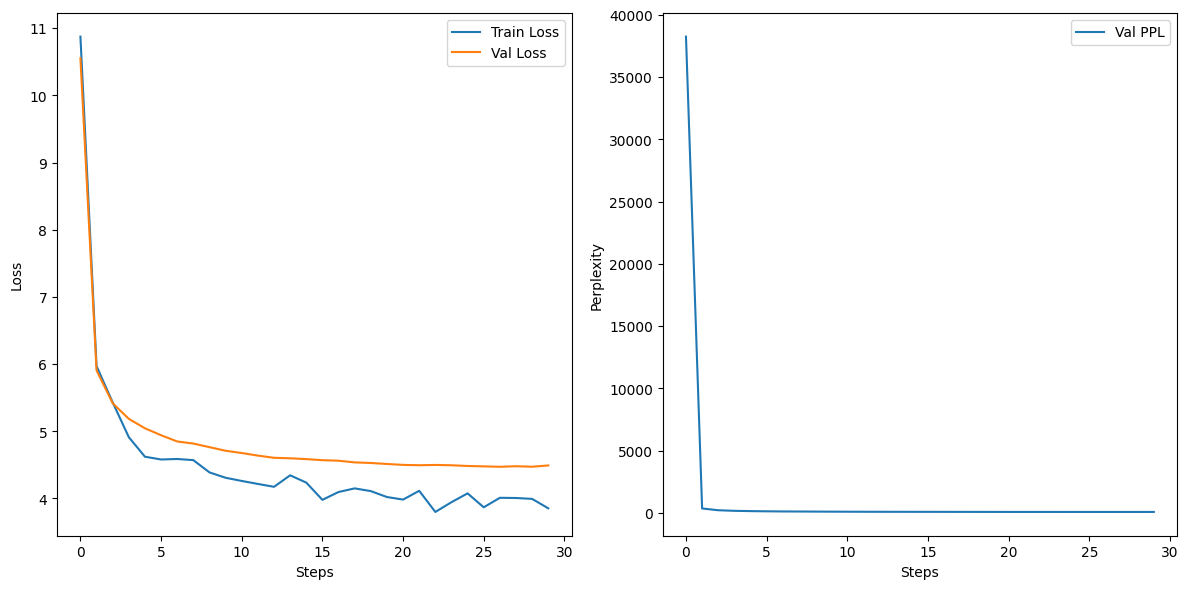

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

with open("/content/harrypotter.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

cleaned_text = prepare_text(raw_text)
tokenizer = tiktoken.get_encoding("gpt2")

split_idx = int(0.9 * len(cleaned_text))
train_loader = create_dataloader(cleaned_text[:split_idx], tokenizer, TRAIN_CONFIG["batch_size"], GPT_CONFIG["context_length"], GPT_CONFIG["context_length"] // 2)
val_loader = create_dataloader(cleaned_text[split_idx:], tokenizer, TRAIN_CONFIG["batch_size"], GPT_CONFIG["context_length"], GPT_CONFIG["context_length"], shuffle=False)

model = GPTModel(GPT_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=TRAIN_CONFIG["learning_rate"], weight_decay=TRAIN_CONFIG["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.98)

train_losses, val_losses, val_ppls = train_model(model, train_loader, val_loader, optimizer, device)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
final_model_path = f"hp_gpt_final_{timestamp}.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Model saved at: {final_model_path}")

steps = list(range(len(train_losses)))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses, label="Train Loss")
plt.plot(steps, val_losses, label="Val Loss")
plt.legend(); plt.xlabel("Steps"); plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(steps, val_ppls, label="Val PPL")
plt.legend(); plt.xlabel("Steps"); plt.ylabel("Perplexity")

plt.tight_layout()
plt.savefig("training_metrics.png")
print("Training plot saved as training_metrics.png")